# Model-Based RL
In this exercise you will implement a policy and model network which work in tandem to solve the CartPole reinforcement learning problem.

What is a model and why would we want to use one? In this case, a model is going to be a neural network that attempts to learn the dynamics of the real environment. For example, in the CartPole we would like a model to be able to predict the next position of the Cart given the previous position and an action. By learning an accurate model, we can train our agent using the model rather than requiring to use the real environment every time. While this may seem less useful when the real environment is itself a simulation, like in our CartPole task, it can have huge advantages when attempting to learn policies for acting in the physical world.

How are we going to accomplish this in Tensorflow? We are going to be using a neural network that will learn the transition dynamics between a previous observation and action, and the expected new observation, reward, and done state. Our training procedure will involve switching between training our model using the real environment, and training our agent’s policy using the model environment. By using this approach we will be able to learn a policy that allows our agent to solve the CartPole task without actually ever training the policy on the real environment! 

### Loading libraries and starting CartPole environment

In [1]:
from __future__ import print_function
import numpy as np
try:
    import cPickle as pickle
except:
    import pickle
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import math

In [2]:
import sys
if sys.version_info.major > 2:
    xrange = range
del sys

In [3]:
import gym
env = gym.make('CartPole-v0')

### Setting Hyper-parameters

In [17]:
# hyperparameters
H = 8 # number of hidden layer neurons
learning_rate = 1e-2
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?

model_bs = 3 # Batch size when learning from model
real_bs = 3 # Batch size when learning from real environment

# model initialization
D = 4 # input dimensionality

### Policy Network

In [18]:
tf.reset_default_graph()
observations = tf.placeholder(tf.float32, [None,4] , name="input_x")
W1 = tf.get_variable("W1", shape=[4, H],
           initializer=tf.contrib.layers.xavier_initializer())
layer1 = tf.nn.relu(tf.matmul(observations,W1))
W2 = tf.get_variable("W2", shape=[H, 1],
           initializer=tf.contrib.layers.xavier_initializer())
score = tf.matmul(layer1,W2)
probability = tf.nn.sigmoid(score)

tvars = tf.trainable_variables()
input_y = tf.placeholder(tf.float32,[None,1], name="input_y")
advantages = tf.placeholder(tf.float32,name="reward_signal")
adam = tf.train.AdamOptimizer(learning_rate=learning_rate)
W1Grad = tf.placeholder(tf.float32,name="batch_grad1")
W2Grad = tf.placeholder(tf.float32,name="batch_grad2")
batchGrad = [W1Grad,W2Grad]

################################################################################
# TODO: Implement the loss function.                                           #
# This sends the weights in the direction of making actions that gave good     #
# advantage (reward overtime) more likely, and actions that didn't less likely.#
################################################################################
loglik = tf.log(input_y*(input_y - probability) + (1 - input_y)*(input_y + probability))
loss = -tf.reduce_mean(loglik * advantages) 
newGrads = tf.gradients(loss,tvars)
adam = tf.train.AdamOptimizer(learning_rate=learning_rate) # Our optimizer
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

newGrads = tf.gradients(loss,tvars)
updateGrads = adam.apply_gradients(zip(batchGrad,tvars))

### Model Network
Here we implement a multi-layer neural network that predicts the next observation, reward, and done state from a current state and action.

In [19]:
mH = 256 # model layer size

input_data = tf.placeholder(tf.float32, [None, 5])
with tf.variable_scope('rnnlm'):
    softmax_w = tf.get_variable("softmax_w", [mH, 50])
    softmax_b = tf.get_variable("softmax_b", [50])

previous_state = tf.placeholder(tf.float32, [None,5] , name="previous_state")
W1M = tf.get_variable("W1M", shape=[5, mH],
           initializer=tf.contrib.layers.xavier_initializer())
B1M = tf.Variable(tf.zeros([mH]),name="B1M")
layer1M = tf.nn.relu(tf.matmul(previous_state,W1M) + B1M)
W2M = tf.get_variable("W2M", shape=[mH, mH],
           initializer=tf.contrib.layers.xavier_initializer())
B2M = tf.Variable(tf.zeros([mH]),name="B2M")
layer2M = tf.nn.relu(tf.matmul(layer1M,W2M) + B2M)
wO = tf.get_variable("wO", shape=[mH, 4],
           initializer=tf.contrib.layers.xavier_initializer())
wR = tf.get_variable("wR", shape=[mH, 1],
           initializer=tf.contrib.layers.xavier_initializer())
wD = tf.get_variable("wD", shape=[mH, 1],
           initializer=tf.contrib.layers.xavier_initializer())

bO = tf.Variable(tf.zeros([4]),name="bO")
bR = tf.Variable(tf.zeros([1]),name="bR")
bD = tf.Variable(tf.ones([1]),name="bD")


predicted_observation = tf.matmul(layer2M,wO,name="predicted_observation") + bO
predicted_reward = tf.matmul(layer2M,wR,name="predicted_reward") + bR
predicted_done = tf.sigmoid(tf.matmul(layer2M,wD,name="predicted_done") + bD)

true_observation = tf.placeholder(tf.float32,[None,4],name="true_observation")
true_reward = tf.placeholder(tf.float32,[None,1],name="true_reward")
true_done = tf.placeholder(tf.float32,[None,1],name="true_done")


predicted_state = tf.concat([predicted_observation,predicted_reward,predicted_done],1)

observation_loss = tf.square(true_observation - predicted_observation)

reward_loss = tf.square(true_reward - predicted_reward)

done_loss = tf.multiply(predicted_done, true_done) + tf.multiply(1-predicted_done, 1-true_done)
done_loss = -tf.log(done_loss)

model_loss = tf.reduce_mean(observation_loss + done_loss + reward_loss)

modelAdam = tf.train.AdamOptimizer(learning_rate=learning_rate)
updateModel = modelAdam.minimize(model_loss)

### Helper-functions

In [20]:
def resetGradBuffer(gradBuffer):
    for ix,grad in enumerate(gradBuffer):
        gradBuffer[ix] = grad * 0
    return gradBuffer

def discount_rewards(r):
    ################################################################################
    # TODO: Implement the discounted rewards function                              #
    # Return discounted rewards weighed by gamma. Each reward will be replaced     #
    # with a weight reward that involves itself and all the other rewards occuring #
    # after it. The later the reward after it happens, the less effect it has on   #
    # the current rewards's discounted reward                                      #
    # Hint: [r0, r1, r2, ..., r_N] will look someting like:                        #
    #       [(r0 + r1*gamma^1 + ... r_N*gamma^N), (r1 + r2*gamma^1 + ...), ...]    #
    ################################################################################
    discounted_rewards = np.zeros(r.shape)
    running_discount = 0
    for i in reversed(range(len(r))):
        running_discount = running_discount * gamma + r[i]
        discounted_rewards[i] = running_discount
    return discounted_rewards
    ################################################################################
    #                                 END OF YOUR CODE                             #
    ################################################################################

# This function uses our model to produce a new state when given a previous state and action
def stepModel(sess, xs, action):
    toFeed = np.reshape(np.hstack([xs[-1][0],np.array(action)]),[1,5])
    myPredict = sess.run([predicted_state],feed_dict={previous_state: toFeed})
    reward = myPredict[0][:,4]
    observation = myPredict[0][:,0:4]
    observation[:,0] = np.clip(observation[:,0],-2.4,2.4)
    observation[:,2] = np.clip(observation[:,2],-0.4,0.4)
    doneP = np.clip(myPredict[0][:,5],0,1)
    if doneP > 0.1 or len(xs)>= 300:
        done = True
    else:
        done = False
    return observation, reward, done

## Training the Policy and Model

In [21]:
xs,drs,ys,ds = [],[],[],[]
running_reward = None
reward_sum = 0
episode_number = 1
real_episodes = 1
init = tf.global_variables_initializer()
batch_size = real_bs

drawFromModel = False # When set to True, will use model for observations
trainTheModel = True # Whether to train the model
trainThePolicy = False # Whether to train the policy
switch_point = 1

# Launch the graph
with tf.Session() as sess:
    rendering = False
    sess.run(init)
    observation = env.reset()
    x = observation
    gradBuffer = sess.run(tvars)
    gradBuffer = resetGradBuffer(gradBuffer)
    
    while episode_number <= 5000:
        # Start displaying environment once performance is acceptably high.
        if (reward_sum/batch_size > 150 and drawFromModel == False) or rendering == True : 
            #env.render()
            #rendering = True
            pass # seriously rendering this is so slow
            
        x = np.reshape(observation,[1,4])

        tfprob = sess.run(probability,feed_dict={observations: x})
        action = 1 if np.random.uniform() < tfprob else 0

        # record various intermediates (needed later for backprop)
        xs.append(x) 
        y = 1 if action == 0 else 0 
        ys.append(y)
        
        # step the  model or real environment and get new measurements
        if drawFromModel == False:
            observation, reward, done, info = env.step(action)
        else:
            observation, reward, done = stepModel(sess,xs,action)
                
        reward_sum += reward
        
        ds.append(done*1)
        drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

        if done: 
            
            if drawFromModel == False: 
                real_episodes += 1
            episode_number += 1

            # stack together all inputs, hidden states, action gradients, and rewards for this episode
            epx = np.vstack(xs)
            epy = np.vstack(ys)
            epr = np.vstack(drs)
            epd = np.vstack(ds)
            xs,drs,ys,ds = [],[],[],[] # reset array memory
            
            if trainTheModel == True:
                ################################################################################
                # TODO: Run the model network and compute predicted_state                      #
                # Output: 'pState'                                                             #
                ################################################################################
                actions = np.array([np.abs(y-1) for y in epy][:-1])
                
                # Get all the prev variables
                prev_state = epx[: -1, :]
                prev_state = np.hstack([prev_state,actions])
                
                # Get all the variables for next state
                next_state = epx[1: , :]
                rewards = np.array(epr[1: , :])
                dones = np.array(epd[1: , :])

                pState, _ = sess.run([predicted_state,updateModel],feed_dict={previous_state: prev_state, 
                                                                                              true_observation: next_state,
                                                                                              true_done:dones,
                                                                                              true_reward:rewards})
                ################################################################################
                #                                 END OF YOUR CODE                             #
                ################################################################################
                

            if trainThePolicy == True:
                ################################################################################
                # TODO: Run the policy network and compute newGrads                            #
                # Output: 'tGrad'                                                              #
                ################################################################################
                # compute the discounted reward backwards through time
                discounted_epr = discount_rewards(epr)
                # size the rewards to be unit normal (helps control the gradient estimator variance)
                discounted_epr -= np.mean(discounted_epr)
                discounted_epr //= np.std(discounted_epr)
                tGrad = sess.run(newGrads, feed_dict={input_y: epy, observations: epx, advantages: discounted_epr})
                ################################################################################
                #                                 END OF YOUR CODE                             #
                ################################################################################
                
                # If gradients becom too large, end training process
                if np.sum(tGrad[0] == tGrad[0]) == 0:
                    break
                for ix,grad in enumerate(tGrad):
                    gradBuffer[ix] += grad
                
            if switch_point + batch_size == episode_number: 
                switch_point = episode_number
                if trainThePolicy == True:
                    
                    ################################################################################
                    # TODO:                                                                        #
                    # (1) Run the policy network and update gradients                              #
                    # (2) Reset gradBuffer to 0                                                    #
                    ################################################################################
                    _ = sess.run(updateGrads, feed_dict={W1Grad: gradBuffer[0], 
                                                         W2Grad: gradBuffer[1]})
                    for ix,grad in enumerate(gradBuffer):
                        gradBuffer[ix] = grad * 0
                    ################################################################################
                    #                                 END OF YOUR CODE                             #
                    ################################################################################

                running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
                if drawFromModel == False:
                    print('World Perf: Episode %f. Reward %f. action: %f. mean reward %f.' % (real_episodes,reward_sum/real_bs,action, running_reward/real_bs))
                    if reward_sum/batch_size > 200:
                        break
                reward_sum = 0

                # Once the model has been trained on 100 episodes
                if episode_number > 100:

                    ################################################################################
                    # TODO: Alternating between training the policy from the model and training    #
                    # the model from the real environment.                                         #
                    ################################################################################
                    trainThePolicy = not trainThePolicy # Whether to train the policy
                    trainTheModel = not trainTheModel # Whether to train the model
                    drawFromModel = not drawFromModel # When set to True, will use model for observations

                    ################################################################################
                    #                                 END OF YOUR CODE                             #
                    ################################################################################
            
            if drawFromModel == True:
                observation = np.random.uniform(-0.1,0.1,[4]) # Generate reasonable starting point
                batch_size = model_bs
            else:
                observation = env.reset()
                batch_size = real_bs
                
print(real_episodes)

World Perf: Episode 4.000000. Reward 18.000000. action: 0.000000. mean reward 18.000000.
World Perf: Episode 7.000000. Reward 16.000000. action: 1.000000. mean reward 17.980000.
World Perf: Episode 10.000000. Reward 17.000000. action: 0.000000. mean reward 17.970200.
World Perf: Episode 13.000000. Reward 17.666667. action: 1.000000. mean reward 17.967165.
World Perf: Episode 16.000000. Reward 32.666667. action: 1.000000. mean reward 18.114160.
World Perf: Episode 19.000000. Reward 22.333333. action: 0.000000. mean reward 18.156351.
World Perf: Episode 22.000000. Reward 20.000000. action: 1.000000. mean reward 18.174788.
World Perf: Episode 25.000000. Reward 28.333333. action: 0.000000. mean reward 18.276373.
World Perf: Episode 28.000000. Reward 28.333333. action: 0.000000. mean reward 18.376943.
World Perf: Episode 31.000000. Reward 16.000000. action: 1.000000. mean reward 18.353174.
World Perf: Episode 34.000000. Reward 18.000000. action: 1.000000. mean reward 18.349642.
World Perf: 

World Perf: Episode 280.000000. Reward 32.333333. action: 1.000000. mean reward 36.990456.
World Perf: Episode 283.000000. Reward 40.666667. action: 0.000000. mean reward 36.752354.
World Perf: Episode 286.000000. Reward 56.666667. action: 1.000000. mean reward 36.649494.
World Perf: Episode 289.000000. Reward 54.000000. action: 1.000000. mean reward 39.445518.
World Perf: Episode 292.000000. Reward 44.666667. action: 0.000000. mean reward 39.177181.
World Perf: Episode 295.000000. Reward 50.333333. action: 0.000000. mean reward 39.042606.
World Perf: Episode 298.000000. Reward 58.000000. action: 0.000000. mean reward 41.541775.
World Perf: Episode 301.000000. Reward 21.000000. action: 0.000000. mean reward 41.030075.
World Perf: Episode 304.000000. Reward 29.666667. action: 1.000000. mean reward 40.562202.
World Perf: Episode 307.000000. Reward 34.000000. action: 1.000000. mean reward 40.206768.
World Perf: Episode 310.000000. Reward 66.333333. action: 1.000000. mean reward 40.105869.

World Perf: Episode 550.000000. Reward 78.000000. action: 1.000000. mean reward 96.612602.
World Perf: Episode 553.000000. Reward 58.333333. action: 0.000000. mean reward 97.127899.
World Perf: Episode 556.000000. Reward 29.666667. action: 1.000000. mean reward 95.638702.
World Perf: Episode 559.000000. Reward 75.333333. action: 0.000000. mean reward 94.578606.
World Perf: Episode 562.000000. Reward 61.333333. action: 0.000000. mean reward 95.127998.
World Perf: Episode 565.000000. Reward 99.000000. action: 0.000000. mean reward 94.564445.
World Perf: Episode 568.000000. Reward 156.333333. action: 0.000000. mean reward 98.293976.
World Perf: Episode 571.000000. Reward 71.000000. action: 0.000000. mean reward 97.272270.
World Perf: Episode 574.000000. Reward 56.333333. action: 1.000000. mean reward 97.629791.
World Perf: Episode 577.000000. Reward 90.333333. action: 0.000000. mean reward 97.157890.
World Perf: Episode 580.000000. Reward 130.666667. action: 1.000000. mean reward 97.52550

World Perf: Episode 817.000000. Reward 182.000000. action: 1.000000. mean reward 119.735588.
World Perf: Episode 820.000000. Reward 115.000000. action: 0.000000. mean reward 118.979057.
World Perf: Episode 823.000000. Reward 192.000000. action: 0.000000. mean reward 118.919952.
World Perf: Episode 826.000000. Reward 184.333333. action: 1.000000. mean reward 118.788994.
World Perf: Episode 829.000000. Reward 200.000000. action: 0.000000. mean reward 120.588745.
World Perf: Episode 832.000000. Reward 191.666667. action: 1.000000. mean reward 123.249046.
World Perf: Episode 835.000000. Reward 161.333333. action: 0.000000. mean reward 124.570290.
World Perf: Episode 838.000000. Reward 129.000000. action: 0.000000. mean reward 123.598061.
World Perf: Episode 841.000000. Reward 121.333333. action: 0.000000. mean reward 122.542999.
World Perf: Episode 844.000000. Reward 133.333333. action: 1.000000. mean reward 121.944580.
World Perf: Episode 847.000000. Reward 200.000000. action: 0.000000. m

World Perf: Episode 1081.000000. Reward 164.333333. action: 0.000000. mean reward 172.898453.
World Perf: Episode 1084.000000. Reward 190.000000. action: 0.000000. mean reward 171.740707.
World Perf: Episode 1087.000000. Reward 195.000000. action: 1.000000. mean reward 171.221420.
World Perf: Episode 1090.000000. Reward 197.333333. action: 0.000000. mean reward 170.145401.
World Perf: Episode 1093.000000. Reward 143.000000. action: 1.000000. mean reward 168.568710.
World Perf: Episode 1096.000000. Reward 189.000000. action: 1.000000. mean reward 168.154190.
World Perf: Episode 1099.000000. Reward 189.000000. action: 0.000000. mean reward 169.338806.
World Perf: Episode 1102.000000. Reward 200.000000. action: 0.000000. mean reward 168.118484.
World Perf: Episode 1105.000000. Reward 197.000000. action: 0.000000. mean reward 167.172272.
World Perf: Episode 1108.000000. Reward 175.333333. action: 0.000000. mean reward 166.429001.
World Perf: Episode 1111.000000. Reward 200.000000. action: 

World Perf: Episode 1345.000000. Reward 200.000000. action: 1.000000. mean reward 159.265823.
World Perf: Episode 1348.000000. Reward 190.666667. action: 1.000000. mean reward 160.089203.
World Perf: Episode 1351.000000. Reward 200.000000. action: 1.000000. mean reward 160.980164.
World Perf: Episode 1354.000000. Reward 200.000000. action: 1.000000. mean reward 162.696915.
World Perf: Episode 1357.000000. Reward 200.000000. action: 1.000000. mean reward 164.400925.
World Perf: Episode 1360.000000. Reward 200.000000. action: 0.000000. mean reward 163.960403.
World Perf: Episode 1363.000000. Reward 195.666667. action: 0.000000. mean reward 165.594254.
World Perf: Episode 1366.000000. Reward 200.000000. action: 0.000000. mean reward 167.272720.
World Perf: Episode 1369.000000. Reward 200.000000. action: 0.000000. mean reward 168.916077.
World Perf: Episode 1372.000000. Reward 200.000000. action: 1.000000. mean reward 170.584641.
World Perf: Episode 1375.000000. Reward 200.000000. action: 

World Perf: Episode 1609.000000. Reward 200.000000. action: 0.000000. mean reward 199.730057.
World Perf: Episode 1612.000000. Reward 200.000000. action: 1.000000. mean reward 200.725586.
World Perf: Episode 1615.000000. Reward 200.000000. action: 0.000000. mean reward 201.677185.
World Perf: Episode 1618.000000. Reward 200.000000. action: 1.000000. mean reward 202.628159.
World Perf: Episode 1621.000000. Reward 200.000000. action: 1.000000. mean reward 203.595932.
World Perf: Episode 1624.000000. Reward 200.000000. action: 0.000000. mean reward 202.858231.
World Perf: Episode 1627.000000. Reward 200.000000. action: 1.000000. mean reward 203.839478.
World Perf: Episode 1630.000000. Reward 200.000000. action: 0.000000. mean reward 204.760254.
World Perf: Episode 1633.000000. Reward 200.000000. action: 1.000000. mean reward 205.619247.
World Perf: Episode 1636.000000. Reward 200.000000. action: 1.000000. mean reward 206.559891.
World Perf: Episode 1639.000000. Reward 200.000000. action: 

World Perf: Episode 1873.000000. Reward 200.000000. action: 1.000000. mean reward 229.265152.
World Perf: Episode 1876.000000. Reward 200.000000. action: 1.000000. mean reward 227.927322.
World Perf: Episode 1879.000000. Reward 200.000000. action: 1.000000. mean reward 228.085999.
World Perf: Episode 1882.000000. Reward 200.000000. action: 1.000000. mean reward 228.557480.
World Perf: Episode 1885.000000. Reward 200.000000. action: 0.000000. mean reward 228.991928.
World Perf: Episode 1888.000000. Reward 200.000000. action: 0.000000. mean reward 229.426559.
World Perf: Episode 1891.000000. Reward 200.000000. action: 1.000000. mean reward 229.844727.
World Perf: Episode 1894.000000. Reward 200.000000. action: 1.000000. mean reward 230.231079.
World Perf: Episode 1897.000000. Reward 200.000000. action: 0.000000. mean reward 230.623642.
World Perf: Episode 1900.000000. Reward 200.000000. action: 1.000000. mean reward 230.407211.
World Perf: Episode 1903.000000. Reward 200.000000. action: 

World Perf: Episode 2137.000000. Reward 200.000000. action: 0.000000. mean reward 238.232117.
World Perf: Episode 2140.000000. Reward 200.000000. action: 0.000000. mean reward 238.481018.
World Perf: Episode 2143.000000. Reward 200.000000. action: 0.000000. mean reward 238.698013.
World Perf: Episode 2146.000000. Reward 200.000000. action: 1.000000. mean reward 238.916000.
World Perf: Episode 2149.000000. Reward 200.000000. action: 1.000000. mean reward 239.123657.
World Perf: Episode 2152.000000. Reward 200.000000. action: 1.000000. mean reward 239.338882.
World Perf: Episode 2155.000000. Reward 200.000000. action: 0.000000. mean reward 238.894348.
World Perf: Episode 2158.000000. Reward 200.000000. action: 0.000000. mean reward 239.153137.
World Perf: Episode 2161.000000. Reward 200.000000. action: 1.000000. mean reward 239.007568.
World Perf: Episode 2164.000000. Reward 200.000000. action: 1.000000. mean reward 239.230957.
World Perf: Episode 2167.000000. Reward 200.000000. action: 

World Perf: Episode 2401.000000. Reward 200.000000. action: 1.000000. mean reward 230.265320.
World Perf: Episode 2404.000000. Reward 200.000000. action: 1.000000. mean reward 230.661179.
World Perf: Episode 2407.000000. Reward 200.000000. action: 1.000000. mean reward 231.025070.
World Perf: Episode 2410.000000. Reward 200.000000. action: 1.000000. mean reward 231.426498.
World Perf: Episode 2413.000000. Reward 200.000000. action: 1.000000. mean reward 231.789566.
World Perf: Episode 2416.000000. Reward 200.000000. action: 1.000000. mean reward 232.138535.
World Perf: Episode 2419.000000. Reward 200.000000. action: 1.000000. mean reward 232.581161.
World Perf: Episode 2422.000000. Reward 155.333333. action: 0.000000. mean reward 232.489944.
World Perf: Episode 2425.000000. Reward 200.000000. action: 0.000000. mean reward 232.864609.
World Perf: Episode 2428.000000. Reward 200.000000. action: 0.000000. mean reward 233.202530.
World Perf: Episode 2431.000000. Reward 200.000000. action: 

### Checking model representation
Here we can examine how well the model is able to approximate the true environment after training. The green line indicates the real environment, and the blue indicates model predictions.

/home/budiryan/Documents/projects/COMP4901J/assignment4/.env/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


NameError: name 'state_nextsAll' is not defined

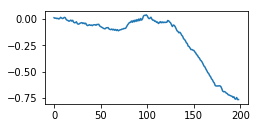

In [22]:
plt.figure(figsize=(8, 12))
for i in range(6):
    plt.subplot(6, 2, 2*i + 1)
    plt.plot(pState[:,i])
    plt.subplot(6,2,2*i+1)
    plt.plot(state_nextsAll[:,i])
plt.tight_layout()